R environment

In [ ]:
suppressPackageStartupMessages({
    library(reticulate)
    library(ggplot2)
    library(Seurat)
    library(dplyr)
    library(tidyr)
    library(purrr)
    library(tibble)
    library(stringr)
    library(dittoSeq)
    library(future)
    library(data.table)
    plan("multiprocess", workers = 8)
    options(future.globals.maxSize = 1000 * 1024^5)
    options(stringsAsFactors = FALSE)
    set.seed(123)
})

In [ ]:
reference <- readRDS('data/coarse_annotation_GBmap.rds')
reference <- subset(reference, idents = 'Malignant')

In [ ]:
use_condaenv("scarches")

In [ ]:
sc <- import("scanpy")
adata <- sc$read_h5ad("data/malignant_SCVI_1000hvg.5had")

In [ ]:
# set embeddings
embedding <- adata$obsm["X_umap"]
rownames(embedding) <- colnames(reference) # obs_names from reference_latent does not have cellIDs (only indexes)
colnames(embedding) <- c("umap_1", "umap_2")
reference[["umap2"]] <- CreateDimReducObject(embedding, key = "umap2_")

# set UMAP models
umap.new.model <- list()
umap.new.model$n_epochs <- 500
umap.new.model$alpha <-1
umap.new.model$method <- "umap"
umap.new.model$negative_sample_rate <- 5
umap.new.model$gamma <- 1
umap.new.model$approx_pow <- 0
umap.new.model$metric$cosine <- list()
umap.new.model$embedding <- reference[["umap2"]]@cell.embeddings
ab_param <- uwot:::find_ab_params(spread = 1, min_dist = 0.3)
umap.new.model$a <- ab_param["a"]
umap.new.model$b <- ab_param["b"]
reference[["umap2"]]@misc$model <- umap.new.model

Warning message:
“No assay specified, setting assay as RNA by default.”


In [ ]:
modules <- read.csv('data/malignant_modules_hotspot_1000hvg.csv')
modules

Gene          C            Z          Pval         FDR          Module
1    RP11-620J15.3 0.5528269    157363.93  0            0             4    
2    PLCG2         0.2818317    127257.37  0            0             7    
3    VGF           0.4937284     77214.52  0            0             7    
4    CTD-2339F6.1  0.4711371     73063.76  0            0             4    
5    HBB           0.5990864     57103.00  0            0            -1    
6    RP11-745C15.2 0.4390999     52215.73  0            0            -1    
7    IGFBP2        0.6012649     36322.65  0            0             7    
8    RP11-89N17.4  0.3122856     30000.72  0            0            10    
9    NEAT1         0.5256841     29748.41  0            0             6    
10   MTRNR2L12     0.3747276     29046.93  0            0             7    
11   RP11-161M6.2  0.3663798     24991.23  0            0             4    
12   APOE          0.5202826     24031.52  0            0             7    
13   KISS1R        0.4098593     21841.73  0            0             6    
14   SEPTIN14      0.4063443     21620.09  0            0             6    
15   HSPB1         0.7246509     20075.25  0            0            14    
16   CCL4L2        0.4819535     19716.86  0            0             1    
17   UBE2S         0.5696155     18324.96  0            0             7    
18   CAPS          0.6713672     17241.16  0            0             2    
19   C1QC          0.5604926     16793.90  0            0             1    
20   OTOS          0.3088547     16465.89  0            0             2    
21   VEGFA         0.5571991     16221.59  0            0             6    
22   CCL4          0.4323216     15647.00  0            0             1    
23   HBA1          0.5861976     13965.39  0            0            -1    
24   HBA2          0.6214743     13373.95  0            0            -1    
25   S100A1        0.3433167     13214.08  0            0            10    
26   CCL3          0.3952832     12882.14  0            0             1    
27   AC015936.3    0.3849709     12165.27  0            0             2    
28   SOX4          0.5709505     11574.08  0            0             5    
29   MARCHF9       0.5953860     11504.51  0            0             4    
30   OLIG2         0.5404853     11156.59  0            0             4    
⋮    ⋮             ⋮            ⋮          ⋮            ⋮            ⋮     
971  KRT17         0.0198111027 15.2476799 8.529389e-53 8.784128e-53 NA    
972  CH25H         0.0611398863 14.8874298 1.988843e-50 2.046135e-50 NA    
973  F13A1         0.2123472258 14.8865073 2.016469e-50 2.072425e-50 NA    
974  IL6           0.0440311048 14.5197841 4.539790e-48 4.660975e-48 NA    
975  VDR           0.0070998918 14.2306257 2.957509e-46 3.033343e-46 NA    
976  RUNX2         0.0138542526 13.8829538 4.018135e-44 4.116941e-44 NA    
977  LEFTY2        0.0233005252 12.0389625 1.108633e-33 1.134732e-33 NA    
978  DKK1          0.0307927271 10.7677965 2.442769e-27 2.497719e-27 NA    
979  HGF           0.0390456889 10.3159446 2.984571e-25 3.048591e-25 NA    
980  CALB1         0.0301419561 10.2055630 9.361603e-25 9.552656e-25 NA    
981  CALCB         0.0363392382  9.9768113 9.627776e-24 9.814246e-24 NA    
982  KLRB1         0.0032744272  9.5284298 7.984002e-22 8.130348e-22 NA    
983  H2BC7         0.0176674432  9.1278026 3.495185e-20 3.555631e-20 NA    
984  H3C10         0.0098149611  8.5757022 4.924203e-18 5.004271e-18 NA    
985  CXCR2         0.0101861504  8.5367997 6.899526e-18 7.004594e-18 NA    
986  CXCL10        0.2221912929  7.2589221 1.950935e-13 1.978636e-13 NA    
987  MMP1          0.0518213073  6.9628872 1.666843e-12 1.688798e-12 NA    
988  TPSB2         0.0011456183  6.5071473 3.829565e-11 3.876078e-11 NA    
989  CHIT1         0.0284946943  6.1280412 4.448377e-10 4.497853e-10 NA    
990  WIF1          0.0182961559  5.2384120 8.098210e-08 8.180011e-08 NA    
991  ICAM2         0.0104090164  5.1886427 1.059162e-

In [ ]:
x <- modules %>% group_by(Module) %>% top_n(n = 50, wt = Z) %>% arrange(Module)
x_split <- split(x, x$Module)
x_split[['-1']] <- NULL
x_split

Registered S3 method overwritten by 'cli':
  method     from         
  print.boxx spatstat.geom



$`1`
# A tibble: 35 × 6
# Groups:   Module [1]
   Gene        C      Z  Pval   FDR Module
   <chr>   <dbl>  <dbl> <dbl> <dbl>  <dbl>
 1 CCL4L2 0.482  19717.     0     0      1
 2 C1QC   0.560  16794.     0     0      1
 3 CCL4   0.432  15647.     0     0      1
 4 CCL3   0.395  12882.     0     0      1
 5 APOC1  0.464  10513.     0     0      1
 6 MRC1   0.516   9978.     0     0      1
 7 C1QB   0.350   6918.     0     0      1
 8 CCL20  0.0892  6383.     0     0      1
 9 C1QA   0.291   6215.     0     0      1
10 RGS1   0.590   6139.     0     0      1
# … with 25 more rows

$`2`
# A tibble: 29 × 6
# Groups:   Module [1]
   Gene            C      Z  Pval   FDR Module
   <chr>       <dbl>  <dbl> <dbl> <dbl>  <dbl>
 1 CAPS        0.671 17241.     0     0      2
 2 OTOS        0.309 16466.     0     0      2
 3 AC015936.3  0.385 12165.     0     0      2
 4 IGFBP7-AS1  0.451  8819.     0     0      2
 5 C9orf24     0.683  4488.     0     0      2
 6 LINC01094   0.202  4422.     0     0      2
 7 LINC01088   0.227  3512.     0     0      2
 8 RP3-460G2.2 0.122  3015.     0     0      2
 9 C1orf194    0.641  2979.     0     0      2
10 FAM183A     0.631  2947.     0     0      2
# … with 19 more rows

$`3`
# A tibble: 46 × 6
# Groups:   Module [1]
   Gene      C     Z  Pval   FDR Module
   <chr> <dbl> <dbl> <dbl> <dbl>  <dbl>
 1 RRM2  0.385 5226.     0     0      3
 2 MKI67 0.507 2105.     0     0      3
 3 CENPA 0.390 1879.     0     0      3
 4 CENPF 0.519 1549.     0     0      3
 5 GTSE1 0.439 1502.     0     0      3
 6 ASPM  0.438 1376.     0     0      3
 7 PIF1  0.288 1360.     0     0      3
 8 HMGB2 0.618 1200.     0     0      3
 9 BIRC5 0.520 1120.     0     0      3
10 CENPE 0.400 1096.     0     0      3
# … with 36 more rows

$`4`
# A tibble: 38 × 6
# Groups:   Module [1]
   Gene              C       Z  Pval   FDR Module
   <chr>         <dbl>   <dbl> <dbl> <dbl>  <dbl>
 1 RP11-620J15.3 0.553 157364.     0     0      4
 2 CTD-2339F6.1  0.471  73064.     0     0      4
 3 RP11-161M6.2  0.366  24991.     0     0      4
 4 MARCHF9       0.595  11505.     0     0      4
 5 OLIG2         0.540  11157.     0     0      4
 6 OLIG1         0.577   5118.     0     0      4
 7 DLL3          0.468   3242.     0     0      4
 8 RGCC          0.437   2423.     0     0      4
 9 FERMT1        0.476   2291.     0     0      4
10 SHD           0.381   1592.     0     0      4
# … with 28 more rows

$`5`
# A tibble: 50 × 6
# Groups:   Module [1]
   Gene          C      Z  Pval   FDR Module
   <chr>     <dbl>  <dbl> <dbl> <dbl>  <dbl>
 1 SOX4      0.571 11574.     0     0      5
 2 BHLHE22   0.238  9530.     0     0      5
 3 LINC00632 0.259  8094.     0     0      5
 4 BASP1     0.533  7140.     0     0      5
 5 STMN4     0.540  5587.     0     0      5
 6 HES6      0.499  5139.     0     0      5
 7 GADD45G   0.338  4942.     0     0      5
 8 SOX11     0.418  4446.     0     0      5
 9 INSM1     0.358  3755.     0     0      5
10 STMN2     0.662  3205.     0     0      5
# … with 40 more rows

$`6`
# A tibble: 38 × 6
# Groups:   Module [1]
   Gene              C      Z  Pval   FDR Module
   <chr>         <dbl>  <dbl> <dbl> <dbl>  <dbl>
 1 NEAT1        0.526  29748.     0     0      6
 2 KISS1R       0.410  21842.     0     0      6
 3 SEPTIN14     0.406  21620.     0     0      6
 4 VEGFA        0.557  16222.     0     0      6
 5 JUN          0.605  11037.     0     0      6
 6 IGFBP5       0.449  10255.     0     0      6
 7 CEBPB        0.418   9839.     0     0      6
 8 NPW          0.0988  8641.     0     0      6
 9 CEBPD        0.428   5565.     0     0      6
10 CTD-3252C9.4 0.255   4830.     0     0      6
# … with 28 more rows

$`7`
# A tibble: 48 × 6
# Groups:   Module [1]
   Gene          C       Z  Pval   FDR Module
   <chr>     <dbl>   <dbl> <dbl> <dbl>  <dbl>
 1 PLCG2     0.282 127257.     0     0      7
 2 VGF       0.494  77215.     0     0      7
 3 IGFBP2    0.601  36323.     0     0      7
 4 MTRNR2L12 0.

In [ ]:
signatures.list <- list()

for(i in 1:length(x_split)){
  gene.names <- x_split[[i]]$Gene
  signatures.list <- append(signatures.list, list(gene.names))
}

names(signatures.list) <- letters[1:length(x_split)]

signatures.list

$a
 [1] "CCL4L2"   "C1QC"     "CCL4"     "CCL3"     "APOC1"    "MRC1"    
 [7] "C1QB"     "CCL20"    "C1QA"     "RGS1"     "AIF1"     "TYROBP"  
[13] "HLA-DQA1" "CYBA"     "ALOX5AP"  "ITGB2"    "HLA-DRB5" "S100A8"  
[19] "HLA-DPA1" "S100A9"   "HLA-DRB1" "CD74"     "FCER1G"   "FCGBP"   
[25] "HLA-DRA"  "KLF4"     "S100A4"   "NCKAP1L"  "IL1RN"    "SAMSN1"  
[31] "IER3"     "GIMAP7"   "ERMN"     "MOBP"     "SPP1"    

$b
 [1] "CAPS"        "OTOS"        "AC015936.3"  "IGFBP7-AS1"  "C9orf24"    
 [6] "LINC01094"   "LINC01088"   "RP3-460G2.2" "C1orf194"    "FAM183A"    
[11] "RSPH1"       "DYNLT5"      "CFAP126"     "PIFO"        "C5orf49"    
[16] "TPPP3"       "CCDC146"     "MORN5"       "HOATZ"       "EFHC1"      
[21] "CRB2"        "HES1"        "PGAM2"       "IFI27"       "CFAP300"    
[26] "SPEF2"       "GABRG1"      "ANXA1"       "MGST1"      

$c
 [1] "RRM2"     "MKI67"    "CENPA"    "CENPF"    "GTSE1"    "ASPM"    
 [7] "PIF1"     "HMGB2"    "BIRC5"    "CENPE"    "TOP2A"    "CLSPN"   
[13] "C21orf58" "ECRG4"    "SGO2"     "PTTG1"    "H4C3"     "PCLAF"   
[19] "PERP"     "SCGB1D2"  "NUSAP1"   "TUBA1B"   "SGO1"     "UBE2C"   
[25] "MYBPHL"   "FRZB"     "AURKB"    "NUF2"     "TPX2"     "HMGN5"   
[31] "APOLD1"   "PRC1"     "CENPU"    "RARRES2"  "TYMS"     "IQCA1"   
[37] "HMMR"     "CKAP2"    "FBLN1"    "AURKA"    "CCNB1"    "ARL6IP1" 
[43] "SVIP"     "UBE2T"    "CKS2"     "DLGAP5"  

$d
 [1] "RP11-620J15.3" "CTD-2339F6.1"  "RP11-161M6.2"  "MARCHF9"      
 [5] "OLIG2"         "OLIG1"         "DLL3"          "RGCC"         
 [9] "FERMT1"        "SHD"           "FGF12"         "CDKN2A"       
[13] "SMOC1"         "SCRG1"         "CDK4"          "TSFM"         
[17] "CADM2"         "RBP1"          "SOX8"          "BCAN"         
[21] "SCG3"          "TNK2"          "GRIA2"         "COL20A1"      
[25] "SNCA"          "TNR"           "APOD"          "NEU4"         
[29] "ASCL1"         "NKAIN4"        "GLCCI1"        "ITM2A"        
[33] "COL11A1"       "SNX22"         "TMEM100"       "VCAN"         
[37] "VIPR2"         "PLLP"         

$e
 [1] "SOX4"      "BHLHE22"   "LINC00632" "BASP1"     "STMN4"     "HES6"     
 [7] "GADD45G"   "SOX11"     "INSM1"     "STMN2"     "KISS1"     "HMGA2"    
[13] "MEG3"      "HAP1"      "CHD5"      "DTX3"      "CELF4"     "RPRM"     
[19] "DLX2"      "KLHL35"    "NSG1"      "MDM4"      "KLHDC8A"   "LY6H"     
[25] "DCX"       "NHLH1"     "STMN1"     "DLX6-AS1"  "THSD7A"    "SYT1"     
[31] "MIAT"      "AGAP2"     "SYP"       "ELAVL4"    "ENC1"      "SNRPE"    
[37] "ARX"       "AVIL"      "ATP1B1"    "NSG2"      "TSPAN31"   "MYT1L"    
[43] "PEG10"     "TMSB15A"   "AGAP2-AS1" "NNAT"      "DLX5"      "SLC35E3"  
[49] "STC1"      "PCP4"     

$f
 [1] "NEAT1"         "KISS1R"        "SEPTIN14"      "VEGFA"        
 [5] "JUN"           "IGFBP5"        "CEBPB"         "NPW"          
 [9] "CEBPD"         "CTD-3252C9.4"  "ZFP36L2"       "AKAP12"       
[13] "CITED2"        "NDRG1"         "COX7A1"        "SOCS3"        
[17] "S100A10"       "LINC02154"     "MAFB"          "FTL"          
[21] "APLN"          "MYL9"          "SPINK1"        "NRN1"         
[25] "ATF5"          "KB-1980E6.3"   "KLF6"          "GADD45B"      
[29] "CAV1"          "NUPR1"         "HMOX1"         "DNAJB9"       
[33] "RP11-386I14.4" "JUNB"          "ERO1A"         "HSPA5"        
[37] "IGFBP6"        "TRIB3"        

$g
 [1] "PLCG2"          "VGF"            "IGFBP2"         "MTRNR2L12"     
 [5] "APOE"           "UBE2S"          "TMEM158"        "IGF2"          
 [9] "C1QL1"          "TTC9B"          "GAS1"           "MT3"           
[13] "LINC00844"      "NTM"            "KCNQ1OT1"       "MDFI"          
[17] "RP11-473M20.16" "FAM215B"        "HES5"           "SNHG19"        
[21] "RIC3"           "RP11-160E2.6"   "COL9A3"         "FABP7"         
[25] "NES"            "RP11-138A9.2"   "MIR9-1HG"       "XIST"          
[29] "CST3"           "PTN"            "EGFR"           "CCND1"         
[33] "C11orf96"       "HMGA1"  

In [ ]:
reference <- AddModuleScore(object = reference,
                                       features =signatures.list,
                                       name = names(signatures.list)
                                      )

Warning message:
“The following features are not present in the object: RP3-460G2.2, HOATZ, CFAP300, GABRG1, not searching for symbol synonyms”
Warning message:
“The following features are not present in the object: SCGB1D2, not searching for symbol synonyms”
Warning message:
“The following features are not present in the object: CTD-2339F6.1, not searching for symbol synonyms”
Warning message:
“The following features are not present in the object: KISS1, SNRPE, not searching for symbol synonyms”
Warning message:
“The following features are not present in the object: KB-1980E6.3, not searching for symbol synonyms”
Warning message:
“The following features are not present in the object: SESN3, not searching for symbol synonyms”
Warning message:
“The following features are not present in the object: RP3-428L16.2, TMSB10, not searching for symbol synonyms”


Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To di

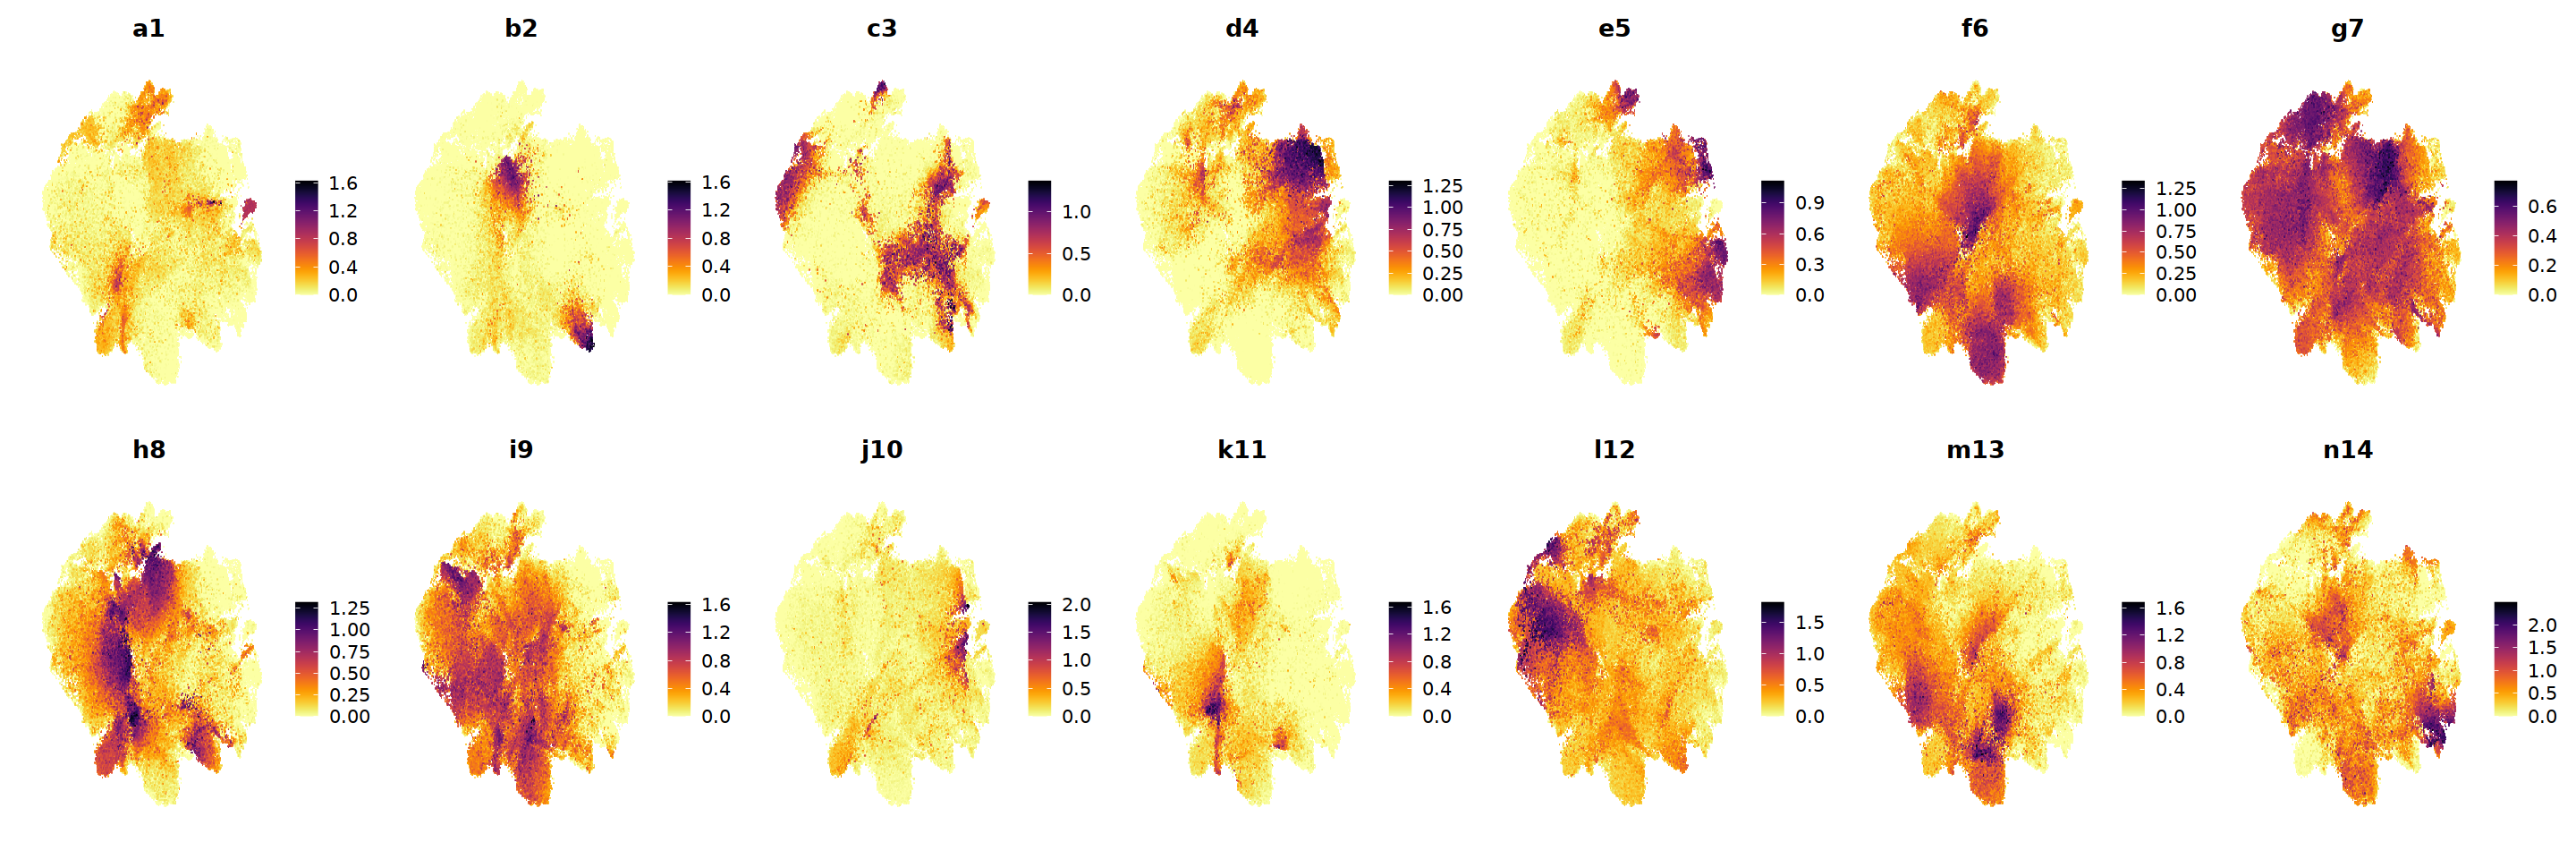

In [ ]:
options(repr.plot.height = 8, repr.plot.width = 24)
p <- FeaturePlot(reference, c('a1','b2','c3','d4','e5','f6','g7','h8','i9','j10','k11','l12','m13','n14'), 
                 reduction = 'umap2', order = TRUE,
                 min.cutoff = 0, pt.size = 1, ncol = 7,
                raster = TRUE) & 
  viridis::scale_colour_viridis(option = 'inferno', direction = -1) 
p & NoAxes() 

# In the manuscript, the number of the modules where arranged in order from top to bottom
# The matching modules dispalyed in Figure 2 and Supp Fig 2 are as follows:
# a1 = Module 1 - MHC-ii/Cytokine
# b2 = Module 8 - Cytoskeleton
# c3 = Module 6 - Cell cycle
# d4 = Module 3 - OPC-I
# e5 = Module 5 - NPC
# f6 = Module 10 - MES-I
# g7 = Module 14 - AC-II
# h8 = Module 9 - AC-I
# i9 = Module 11 - MES-II
# j10 = Module 4 - OPC-II
# k11 = Module 13 - MES-III
# l12 = Module 2 - Malignant core-signature
# m13 = Module 12 - Hypoxia
# n14 = Module 7 - Stress signature

In [ ]:
ggsave('../figures/malignant_module_scores_inferno.pdf', height = 7, width = 25)

For cell annotation, we considered the results from the gene module detection perfomed using Hotspot <br>
and the expression of cell type-specific marker genes identified using the Wilcoxon rank-sum test <br>
by comparing all cells within a specific cluster to all cells outside said cluster. 

In [ ]:
reference <- AddMetaData(reference,
                         adata$obs['leiden_1.2'] %>% `rownames<-` (colnames(reference)))

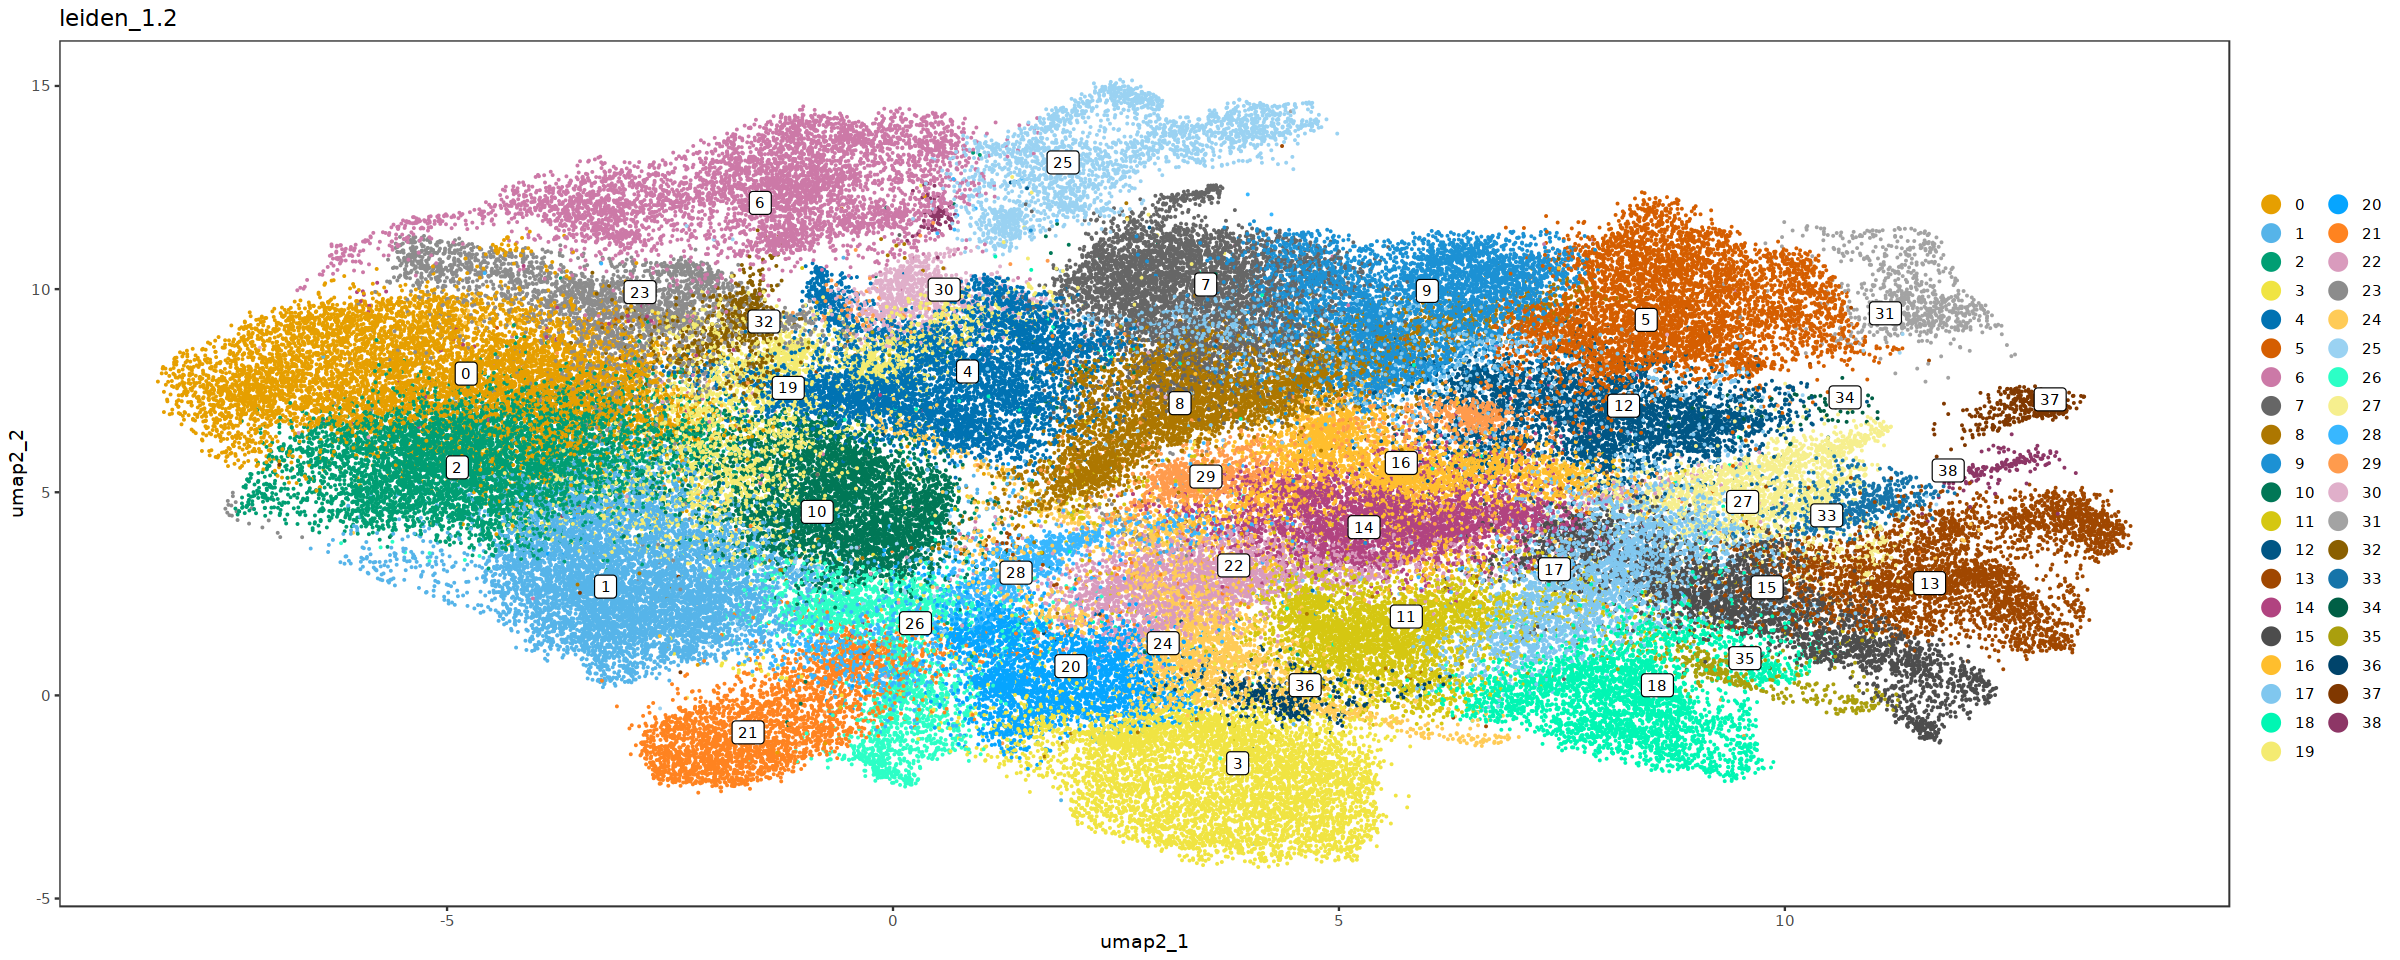

In [ ]:
dittoDimPlot(reference, 
             reduction.use = "umap2", var = "leiden_1.2", 
             do.label = TRUE, labels.size = 3, size = 0.5)

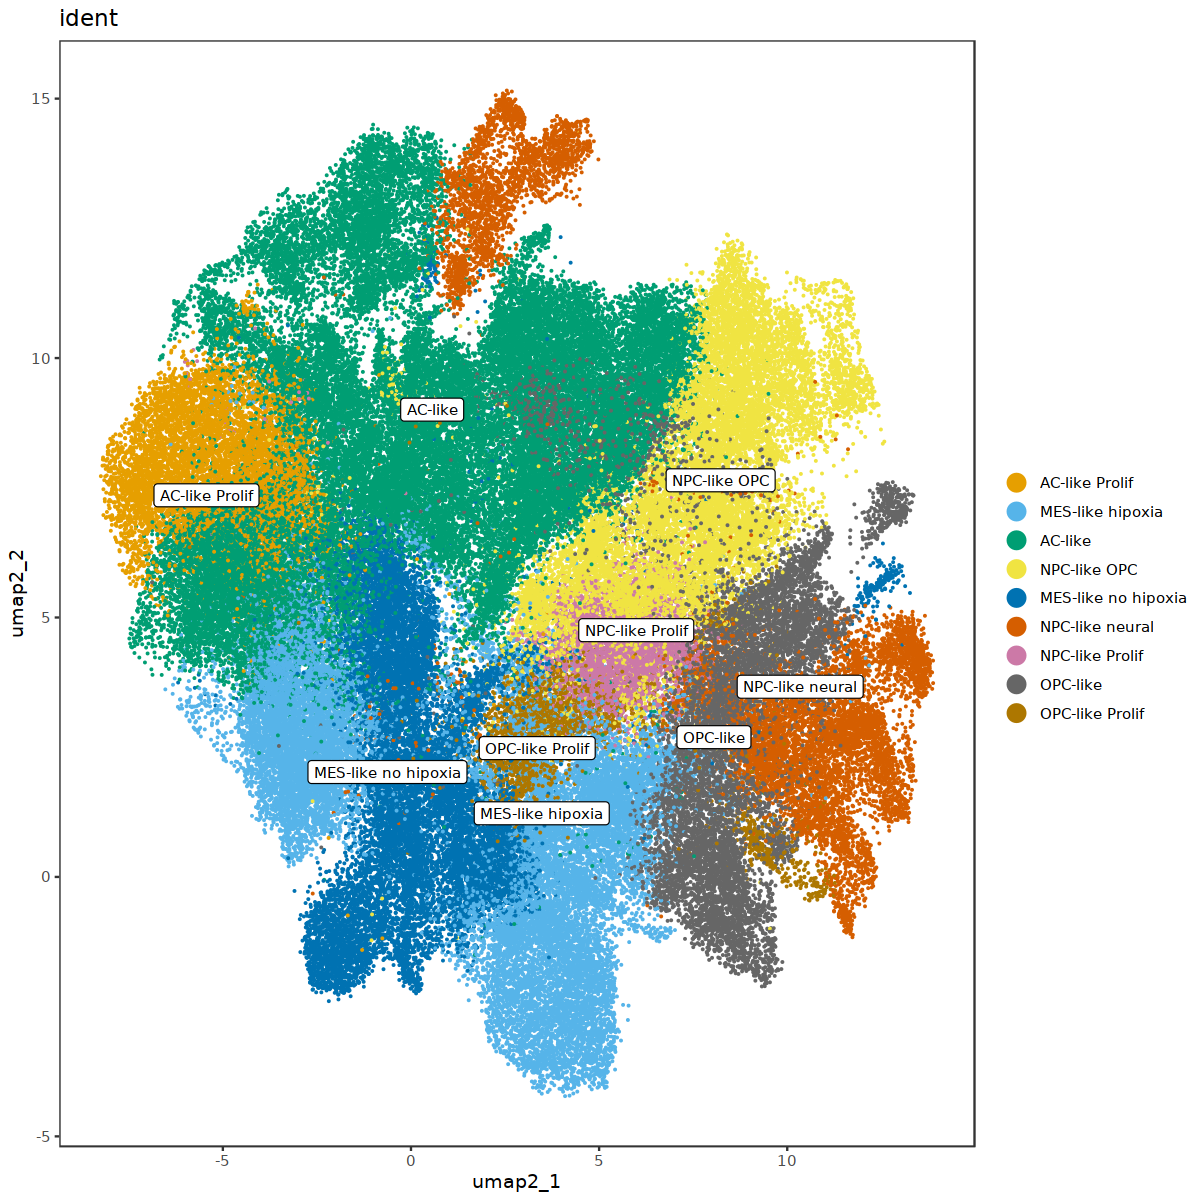

In [ ]:
Idents(reference) <- reference@meta.data$`leiden_1.2`

reference <- RenameIdents(reference, `0` = "AC-like Prolif",
                    `1` = "MES-like hipoxia",
                    `2` = "AC-like", 
                    `3` = "MES-like hipoxia", 
                    `4` = "AC-like", 
                    `5` = "NPC-like OPC", 
                    `6` = "AC-like", 
                    `7` = "AC-like", 
                    `8` = "AC-like", 
                    `9` = "AC-like",
                    `10` = "MES-like no hipoxia",
                    `11` = "MES-like hipoxia", 
                    `12` = "NPC-like OPC", 
                    `13` = "NPC-like neural", 
                    `14` = "NPC-like Prolif",
                    `15` = "NPC-like neural",
                    `16` = "NPC-like OPC", 
                    `17` = "OPC-like", 
                    `18` = "OPC-like", 
                    `19` = "AC-like", 
                    `20` = "MES-like no hipoxia", 
                    `21` = "MES-like no hipoxia", 
                    `22` = "OPC-like Prolif", 
                    `23` = "AC-like",
                    `24` = "MES-like hipoxia",
                    `25` = "NPC-like neural", 
                    `26` = "MES-like no hipoxia", 
                    `27` = "OPC-like", 
                    `28` = "MES-like no hipoxia",
                    `29` = "NPC-like OPC",
                    `30` = "AC-like", 
                    `31` = "NPC-like OPC", 
                    `32` = "AC-like", 
                    `33` = "OPC-like", 
                    `34` = "NPC-like OPC", 
                    `35` = "OPC-like Prolif", 
                    `36` = "MES-like hipoxia", 
                    `37` = "OPC-like",
                    `38` = "MES-like no hipoxia"
                        )

options(repr.plot.height = 10, repr.plot.width = 10)
dittoDimPlot(reference, 
             reduction.use = "umap2", var = "ident", 
             do.label = TRUE, labels.size = 3, size = 0.5)

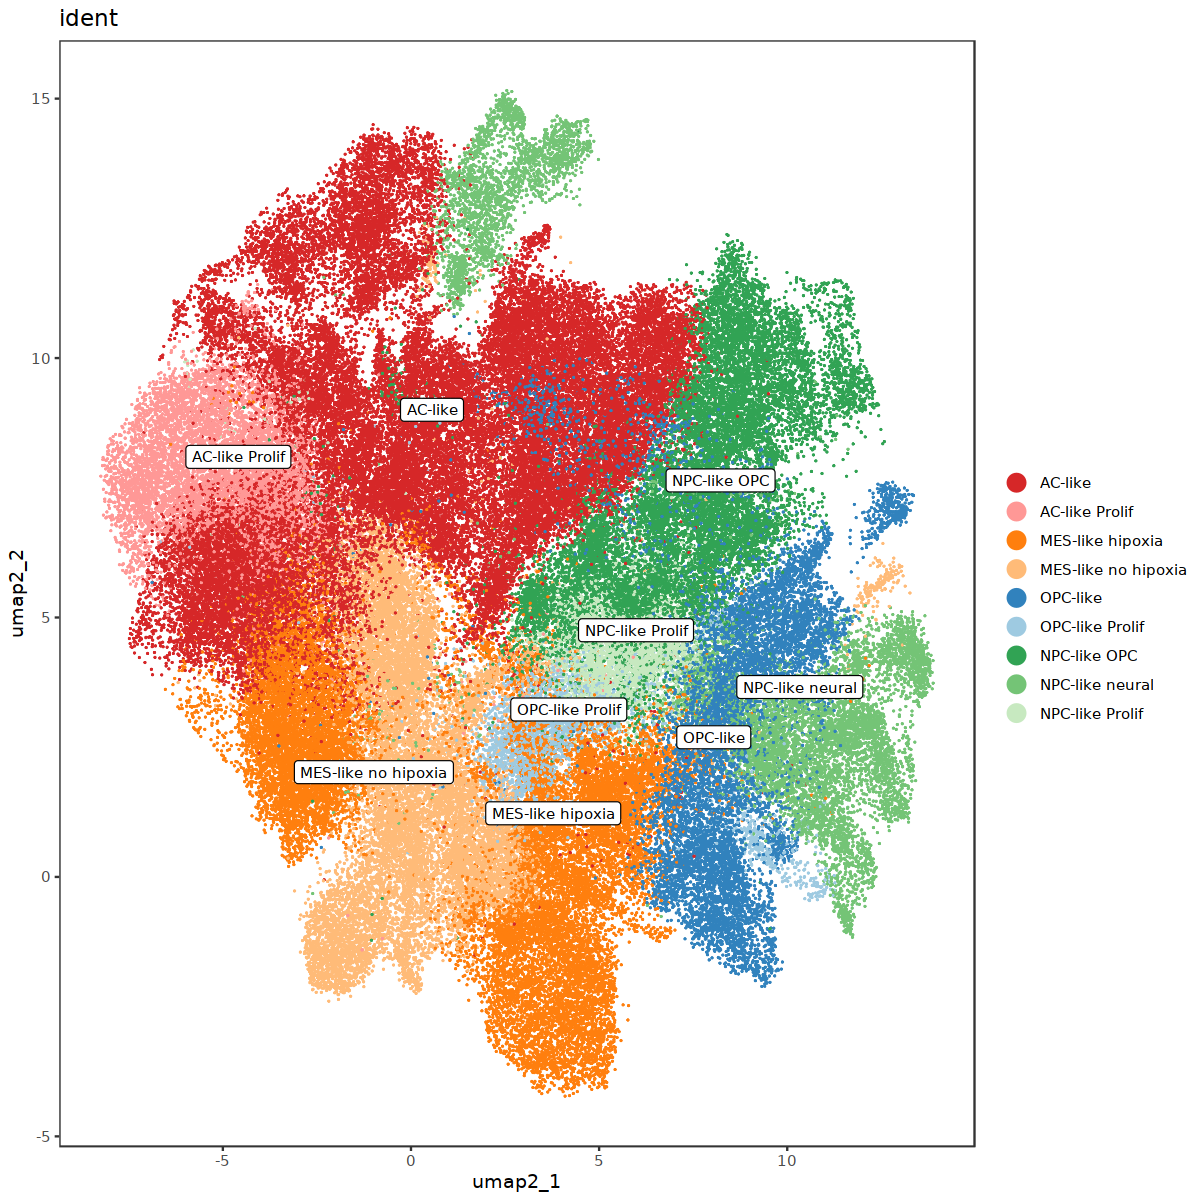

In [ ]:
reference@active.ident <- factor(x = reference@active.ident, 
                                   levels = c('AC-like', 'AC-like Prolif','MES-like hipoxia','MES-like no hipoxia',
     'OPC-like','OPC-like Prolif','NPC-like OPC','NPC-like neural','NPC-like Prolif'))

options(repr.plot.height = 10, repr.plot.width = 10)
dittoDimPlot(reference, 
             reduction.use = "umap2", var = "ident", 
             color.panel = c('#d62728', '#ff9896', '#ff7f0e','#ffbb78', #AC/MES
                    '#3182bd','#9ecae1','#31a354','#74c476','#c7e9c0' #OPC/NPC
                            ),
             do.raster = TRUE,
             do.label = TRUE, labels.size = 3, size = 0.5)

In [ ]:
ggsave('../figures/subclustering_malignat.pdf', width = 8)

Saving 8 x 6.67 in image



In [ ]:
saveRDS(Idents(reference), 'data/malignant_detailed_cellstates.rds')